# **Drive Mounting**


In [1]:
from google.colab import drive

drive.mount('/content/drive')
!pip install visdom

# !kill -9 -1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    100% |████████████████████████████████| 1.4MB 14.6MB/s 
    100% |████████████████████████████████| 204kB 29.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/ee/87/ce/a5023722374ca73b57fc8d4284ba6f973c01219b3c385a07e0
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


# **Import** 

In [0]:
import numpy as np
import torch
import torch.nn as nn
from visdom import Visdom
import torch.nn.functional as F
from torch import optim
from PIL import Image
import os
from os import listdir
import re
from scipy import misc
import matplotlib.pyplot as plt


# **Unet Model**

In [0]:
# Unet Sub parts
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
      

# Unet model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x



# **Train**

In [0]:

def read_images(path, mode, noise_sigma, channel, gt_suf, noise_suf, im_type):
    # the function get a path to images directory, load all images in the directory and noise them, and then return the
    # loaded images and noised images
    # inputs:  path - a path to the directory with the images
    #          mode - a flag, if 1 a i.i.d gaussian noise will be added to the images, if 0 images will be loaded to
    #                 ground truth and noisy images according to the gt_suf, noise_suf strings
    #          gt_suf - ground truth suffix, a string
    #          noise_suf - noisy image suffix
    #          noise_sigma - the added gaussian noise sigma
    #
    # outputs: x - noised images array
    #          y - same images without noise

    img_list = [f for f in listdir(path) if re.search(r'[.]*\.%s$' % im_type, f)]
    img_list.sort()
    x = []
    y = []
    if mode == 1:
        for img in img_list:
            im_path = path + img
            rgb_img = misc.imread(im_path, mode='L')
            gt = rgb_img.astype(np.float32)
            gt = gt.astype(np.float32)/255
            noisy = torch.tensor(gt) + torch.randn_like(torch.tensor(gt)) * noise_sigma/255
            x.append(gt)
            y.append(noisy)
    elif mode == 0:
        for img in img_list:
            im_path = path + img
            rgb_img = misc.imread(im_path, mode='L')
            gt = rgb_img.astype(np.float32)
            # gt = return_channel(rgb_img, channel)
            gt = gt.astype(np.float32)/255
            if img.find(gt_suf) != -1:
                x.append(gt)
            elif img.find(noise_suf) != -1:
                y.append(gt)

    else:
        print('Wrong mode')
    return x, y


def data_generator(x, y, rows, cols):
    data_shape = np.shape(x)
    cropped_x = np.zeros((data_shape[0], rows, cols))
    cropped_y = np.zeros((data_shape[0], 1, rows, cols))
    for image in range(data_shape[0]):
        image_shape = np.shape(x[image])
        if image_shape[0] <= rows:
            row = 0
        else:
            row = np.random.randint(low=0, high=image_shape[0] - rows - 1)
        if image_shape[1] <= cols:
            col = 0
        else:
            col = np.random.randint(low=0, high=image_shape[1] - cols - 1)
        x_temp = x[image]
        cropped_x[image, :, :] = x_temp[row:row + rows, col:col + cols]
        # plt.figure()
        # plt.imshow(cropped_x[image, :, :, 0])
        y_temp = y[image]
        cropped_y[image, 0, :, :] = y_temp[row:row + rows, col:col + cols]
        # plt.figure()
        # plt.imshow(cropped_y[image, :, :, 0])
    return cropped_x.astype(np.float32), cropped_y.astype(np.float32)
  


# Train the network

def train(epoch, gt, imgs, epoch_train_size):
    # epoch_train_size = 400
    epoch_loss = 0
    avg_psnr = 0
#     (gt, imgs) = data_generator(x, y, 128, 128)
    index = np.arange(len(gt))
    np.random.shuffle(index)
#     if len(gt) > 400:
#       gt_epoch = gt[index[0:399]]
#       imgs_epoch = imgs[index[0:399]]
#     else:
    gt_epoch = gt
    imgs_epoch = imgs
#     print(index)
    criterion = nn.CrossEntropyLoss()
    for i in range(epoch_train_size):

#         masks_pred = net(torch.tensor(imgs_epoch).cuda())
        masks_pred = net(torch.tensor(imgs_epoch))
        true_masks = torch.tensor(gt_epoch) * 255
        true_masks = torch.round(true_masks)

        masks_probs_flat = masks_pred
#         true_masks_flat = true_masks.cuda()
        true_masks_flat = true_masks                 
        loss = criterion(masks_probs_flat, true_masks_flat.long())
        epoch_loss += loss.item()
        img_est = masks_probs_flat.argmax(dim=1)
        img_est = img_est.float() / 255
#         mse = torch.sum((torch.tensor(np.squeeze(imgs_epoch, 1)).cuda() - img_est) ** 2) / imgs_epoch.shape[0] / imgs_epoch.shape[1] / imgs_epoch.shape[2] / imgs_epoch.shape[3]
        mse = torch.sum((torch.tensor(np.squeeze(imgs_epoch, 1)) - img_est) ** 2) / imgs_epoch.shape[0] / imgs_epoch.shape[1] / imgs_epoch.shape[2] / imgs_epoch.shape[3]
        psnr = -10 * np.log10(mse.cpu())
        avg_psnr += psnr
        k = float(i + 1)
        print('train: epoch {0} --i:{1} -- loss: {2}, psnr: {3}'.format(epoch, i, epoch_loss / k, avg_psnr / k))
        # img_shower.plot('image'+str(i), 'train', 'train images', img_est[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return epoch_loss / epoch_train_size, avg_psnr / epoch_train_size
  
def test(epoch, gt, imgs):
    avg_psnr = 0
    epoch_loss = 0
#     (gt, imgs) = data_generator(x, y, 128, 128)
    n = len(gt)
 
    criterion = nn.CrossEntropyLoss()
    masks_pred = net(torch.tensor(imgs))
#     masks_pred = net(torch.tensor(imgs).cuda())
    true_masks = torch.tensor(gt) * 255
    true_masks = torch.round(true_masks)

    masks_probs_flat = masks_pred
#     true_masks_flat = true_masks.cuda()
    true_masks_flat = true_masks
    loss = criterion(masks_probs_flat, true_masks_flat.long())
    epoch_loss += loss.item()
    img_est = masks_probs_flat.argmax(dim=1)
    img_est = img_est.float() / 255
#     mse = torch.sum((torch.tensor(np.squeeze(imgs, 1)).cuda() - img_est) ** 2) / imgs.shape[0] / imgs.shape[1] / \
#           imgs.shape[2] / imgs.shape[3]
    mse = torch.sum((torch.tensor(np.squeeze(imgs, 1)) - img_est) ** 2) / imgs.shape[0] / imgs.shape[1] / \
          imgs.shape[2] / imgs.shape[3]
    psnr = -10 * np.log10(mse.cpu())
    avg_psnr += psnr
    print('test: epoch {0}, loss: {1}, psnr: {2}'.format(epoch, epoch_loss , avg_psnr))
    # if (i % 50 == 0):
    #     img_shower.plot('image' + str(i) + str(epoch), 'test', 'test images' + str(i) + 'epoch' + str(epoch),
    #                     img_est[0])

    return epoch_loss, avg_psnr
  
def denoise_img(net, noised_images, gt_images):
    data_shape = len(noised_images)
    denoised_images = []
    psnr = []
    avg_psnr = 0
    for image in range(data_shape):
        data = np.expand_dims(a=noised_images[image], axis=0)
        data = np.expand_dims(data, axis=0)
        masks_pred = net(torch.tensor(data).cuda())
        true_masks = np.array(np.clip((gt_images[image]) * 255.0, 0, 255))
        img_est = masks_pred.argmax(dim=1)
        gt = torch.tensor(gt_images[image]).cuda()
        mse = torch.sum((gt - img_est.float() / 255) ** 2) / gt.shape[0] / gt.shape[1]
        psnr.append(np.array(-10 * np.log10(mse.cpu())))
        denoised_images.append(img_est.cpu()[0, :, :])

        avg_psnr += psnr[image] / data_shape

    return psnr, avg_psnr, denoised_images
  
  

# **Vizdom**

In [0]:
class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')
            
class VisdomImageShower(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, img):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.image(img, env=self.env, opts=dict(
                title=title_name,
                legend=[split_name]
                ))
        else:
            self.viz.image(img, env=self.env, win=self.plots[var_name])
            
# !python -m visdom.server

# **Main**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


[array(27.337517, dtype=float32), array(22.539112, dtype=float32), array(26.7415, dtype=float32), array(24.731894, dtype=float32), array(24.80713, dtype=float32), array(26.775318, dtype=float32), array(26.781416, dtype=float32), array(29.968946, dtype=float32), array(24.140587, dtype=float32), array(21.395493, dtype=float32), array(30.892351, dtype=float32), array(28.970211, dtype=float32), array(24.93167, dtype=float32), array(23.87587, dtype=float32), array(25.647738, dtype=float32), array(24.90138, dtype=float32), array(24.334814, dtype=float32), array(25.517921, dtype=float32), array(28.513441, dtype=float32), array(26.412052, dtype=float32), array(26.564856, dtype=float32), array(29.175444, dtype=float32), array(24.426716, dtype=float32), array(22.579212, dtype=float32), array(26.709583, dtype=float32), array(28.155329, dtype=float32), array(26.526833, dtype=float32), array(26.547468, dtype=float32), array(26.4833, dtype=float32), array(30.167141, dtype=float32), array(29.727781, 

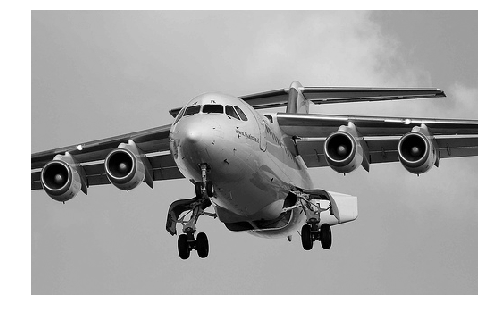

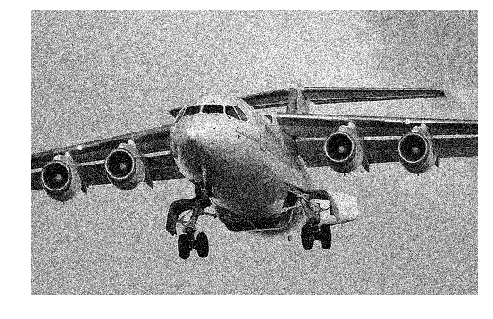

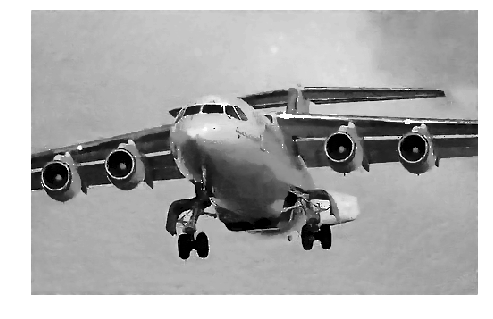

In [11]:
# Parameters
baseFolder = os.getcwd()
baseFolder += '/drive/My Drive/Project'
train_dir = baseFolder + '/train_2/'
test_dir = baseFolder + '/test/'
weights_path = baseFolder + '/Weights/Unet_sigma_35'
noise_sigma = 35
load_weights_flag = 1
train_or_test = 0
lr = 0.01
epoch_num = 50
model_dir = baseFolder + '/Weights/unet_1_ns_{0}'.format(noise_sigma)
# channel = 0
mode = 1
gt_suf = 'mean'
noise_suf = 'Real'
im_type = 'jpg'

net = UNet(n_channels=1, n_classes=256)
if load_weights_flag == 1:
    net.load_state_dict(torch.load(weights_path))
net.cuda()
# global plotter
# global img_shower
# plotter = VisdomLinePlotter(env_name='Denoising by Segmentation Plots')
# img_shower = VisdomImageShower(env_name='Denoising by Segmentation Images')

optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, cooldown=10, eps=1e-06)

if train_or_test == 1:
    (x, y) = read_images(train_dir, mode, noise_sigma, 0, gt_suf, noise_suf, im_type)
    (x_test, y_test) = read_images(test_dir, mode, noise_sigma, 0, gt_suf, noise_suf, im_type)
    loss = np.zeros(epoch_num)
    psnr = np.zeros(epoch_num)
    test_loss = np.zeros(epoch_num)
    test_psnr = np.zeros(epoch_num)
    for epoch in range(epoch_num):
        (gt, imgs) = data_generator(x, y, 128, 128)
        (gt_test, imgs_test) = data_generator(x_test, y_test, 128, 128)
        
        loss[epoch], psnr[epoch] = train(epoch, gt, imgs, 1)
        test_loss[epoch], test_psnr[epoch] = test(epoch, gt_test, imgs_test)
        scheduler.step(test_loss[epoch])
        # plotter.plot('loss', 'train', 'Train Loss', epoch, loss)
        # plotter.plot('psnr', 'train', 'Train PSNR', epoch, psnr)
        # plotter.plot('loss', 'test', 'Test Loss', epoch, test_loss)
        # plotter.plot('psnr', 'test', 'test PSNR', epoch, test_psnr)
        if epoch % 10 == 0:
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            torch.save(net.state_dict(), os.path.join(model_dir, 'Unet_epoch_' + str(epoch)))
            
    plt.figure()
    plt.plot(range(np.shape(loss)[0]),loss, 'b')
    plt.plot(range(np.shape(test_loss)[0]),test_loss, 'r')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(['Training Set', 'Test Set'])
    plt.show()
    plt.figure()
    plt.plot(range(np.shape(psnr)[0]),psnr, 'b')
    plt.plot(range(np.shape(test_psnr)[0]),test_psnr, 'r')
    plt.xlabel('Epoch #')
    plt.ylabel('PSNR')
    plt.legend(['Training Set', 'Test Set'])
    plt.show()
else:
    (x_test, y_test) = read_images(test_dir, mode, noise_sigma, 0, gt_suf, noise_suf, im_type)
    (psnr, avg_psnr, denoised_images) = denoise_img(net, y_test, x_test)
    print(psnr)
    ind = 0
    d = x_test[ind]
    g = denoised_images[ind]
    k = y_test[ind]
    d = np.array(np.clip(d * 255.0, 0, 255), dtype=np.uint8)
#     g = np.array(np.clip(g * 255.0, 0, 255), dtype=np.uint8)
    k = np.array(np.clip(k * 255.0, 0, 255), dtype=np.uint8)
    plt.figure()
    plt.imshow(d, cmap='gray')
    plt.axis('off')
    plt.figure()
    plt.imshow(k, cmap='gray')
    plt.axis('off')
    plt.figure()
    plt.imshow(g, cmap='gray')
    plt.axis('off')
    len(y_test)
        



